<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/conv_lstm_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [241]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [242]:
import glob

folder_path = '/content/drive/MyDrive/opportunistic-utm/dataset/2019-01'
folder_list = []
for folder in glob.iglob(folder_path + '/**/', recursive=False):
  folder_list.append(folder)

In [315]:
folder_list[0]

'/content/drive/MyDrive/opportunistic-utm/dataset/2019-01/2019-01-01/'

In [363]:
import numpy as np
from tqdm import tqdm
%config InlineBackend.figure_format = 'retina'

day_array = []
for folder in tqdm(folder_list):
  files = np.sort(glob.glob(folder + '/*.npy', recursive=False))
  hours_array = np.expand_dims(np.moveaxis(np.load(files[0]), 0, -1), 0)

  for i in range(1, 24):
    next_hour = np.expand_dims(np.moveaxis(np.load(files[i]), 0, -1), 0)
    hours_array = np.concatenate((hours_array, next_hour), axis=0)

  day_array.append(hours_array)

day_array = np.array(day_array)
day_array.shape

100%|██████████| 31/31 [00:01<00:00, 22.39it/s]


(31, 24, 50, 50, 8)

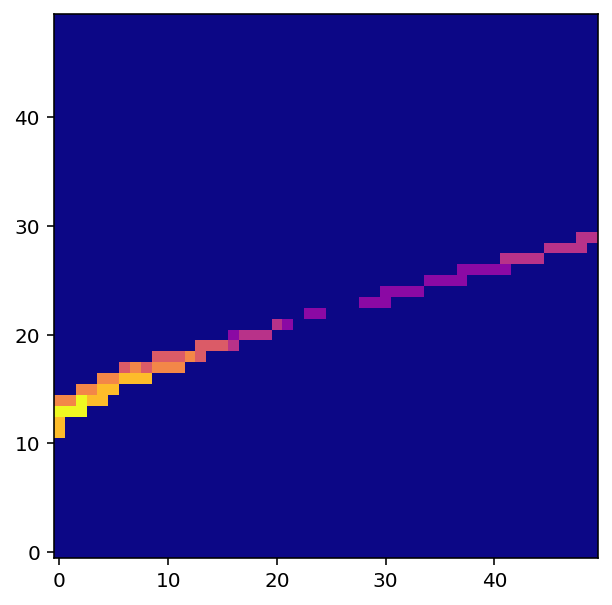

In [372]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))

def level_transform(input_array, hour):
  levels_array = []
  len_array = input_array[hour, ...].shape[-1]
  for i in range(0, len_array):
    level = input_array[hour, ..., i]*((i+2)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

ax.imshow(level_transform(day_array[0], 10), origin='lower', cmap = plt.get_cmap('plasma'))

In [251]:
level_transform(day_array[15], 10).shape

(50, 50)

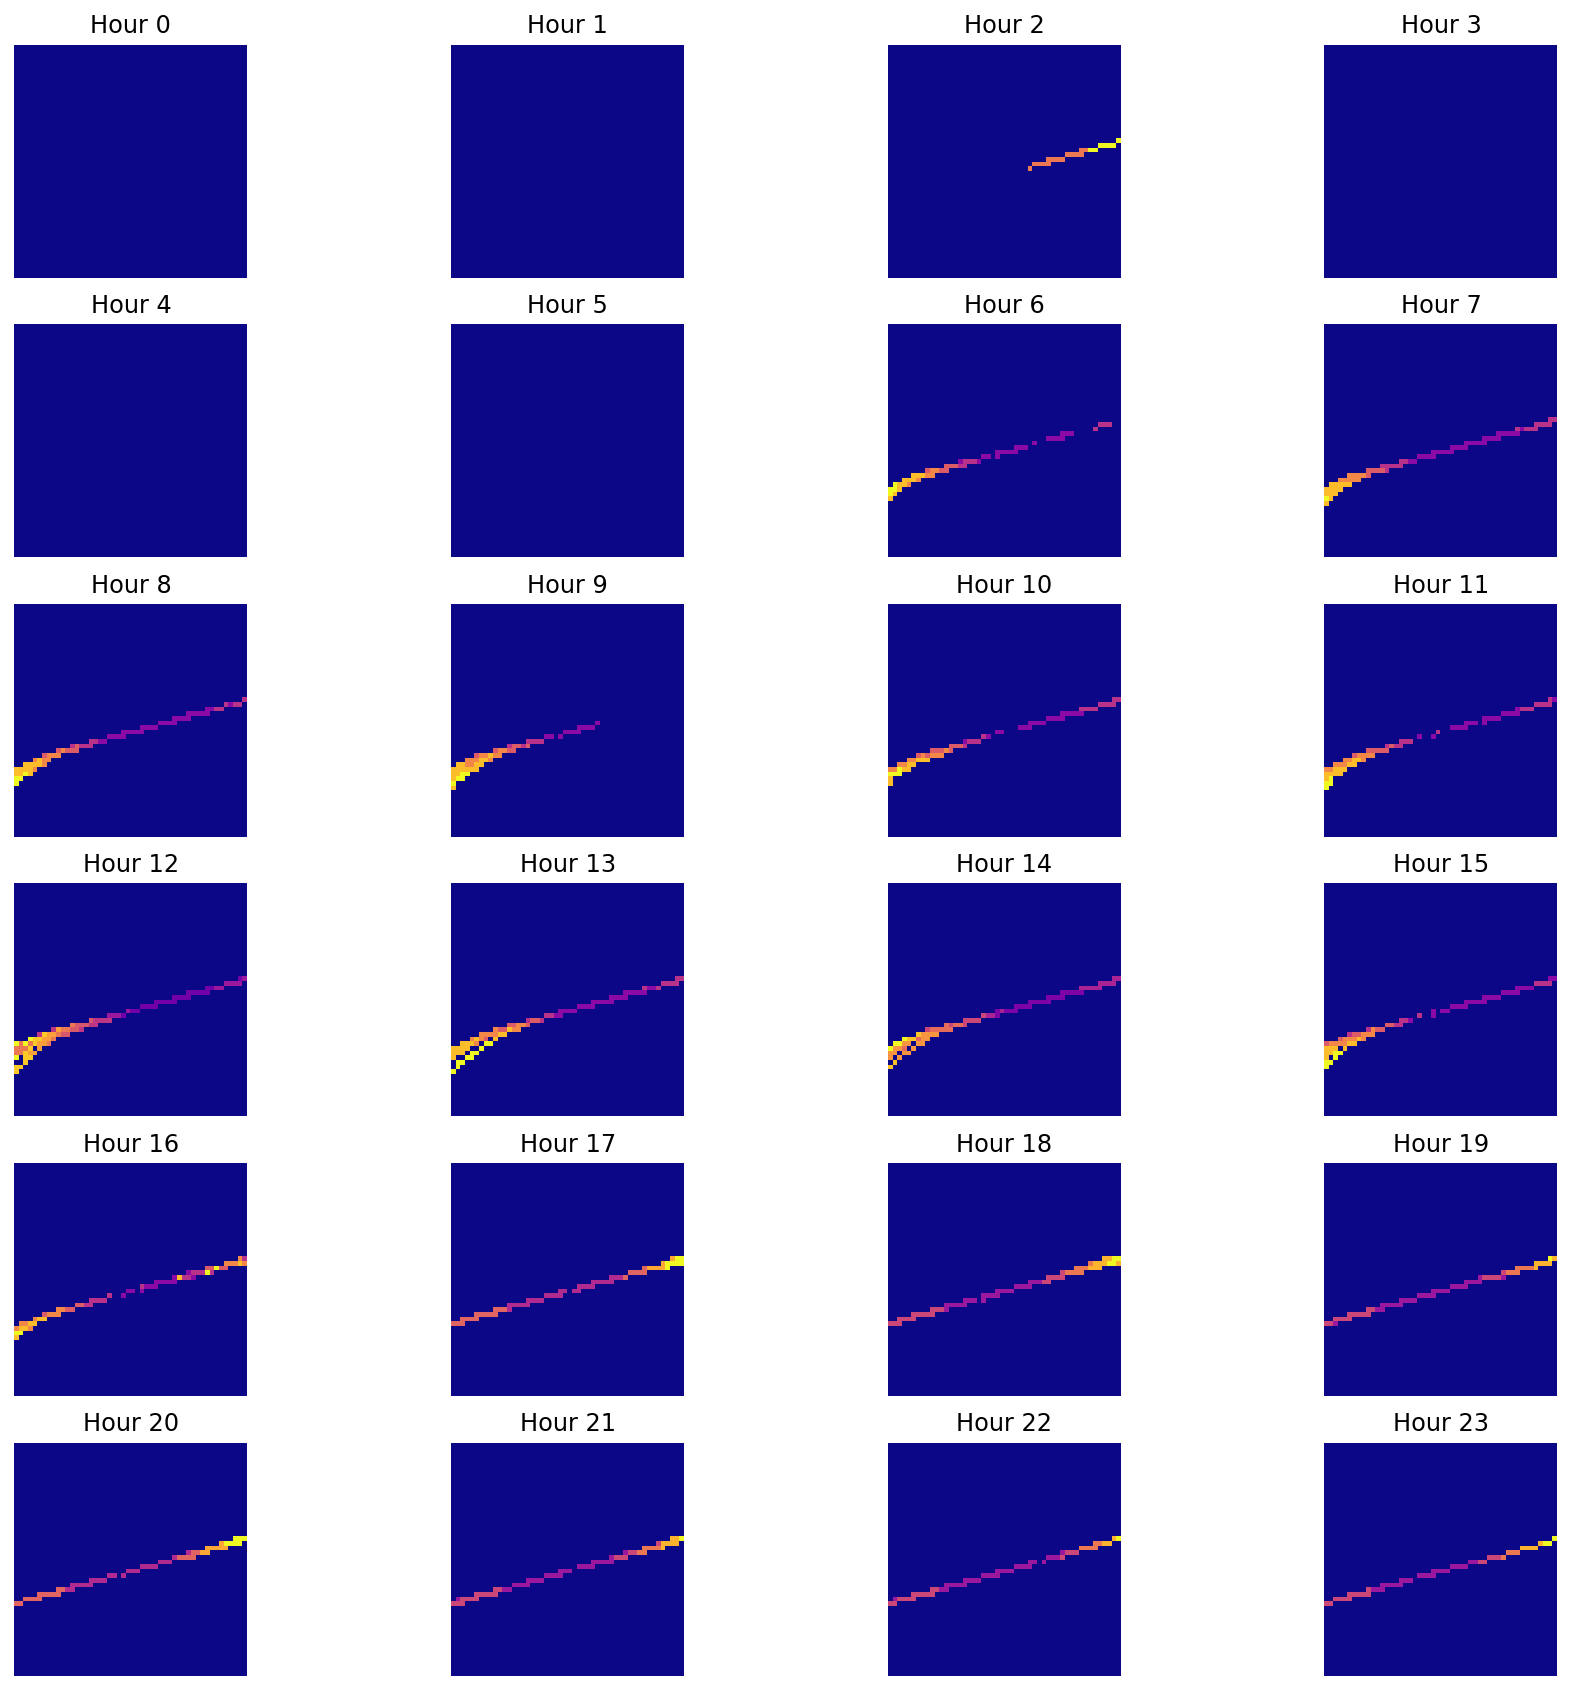

In [373]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6, 4, figsize=(15, 15))
for idx, ax in enumerate(ax.flat):
  ax.imshow(level_transform(day_array[0], idx), origin='lower', cmap = plt.get_cmap('plasma'))
  ax.set_title(f"Hour {idx}")
  ax.axis("off")

In [374]:
x_train = day_array[0:20]
y_train = day_array[1:21]

x_val = day_array[21:27]
y_val = day_array[22:28]

x_test = day_array[28:30]
y_test = day_array[29:31]

# ConvLSTM

In [375]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, GRU, Dropout, TimeDistributed

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [392]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.

a = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
# x = layers.BatchNormalization()(x)

b = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
# x = layers.BatchNormalization()(x)

c = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

x = tf.keras.layers.Concatenate()([a, b, c])
x = TimeDistributed(layers.BatchNormalization())(x)
x = TimeDistributed(layers.Dropout(0.2))(x)

x = layers.ConvLSTM2D(
    filters=8,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
)(x)

# x = layers.Conv3D(
#     filters=8, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
# )(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, None, 50, 5  0           []                               
                                0, 8)]                                                            
                                                                                                  
 conv_lstm2d_72 (ConvLSTM2D)    (None, None, 50, 50  46208       ['input_22[0][0]']               
                                , 32)                                                             
                                                                                                  
 conv_lstm2d_73 (ConvLSTM2D)    (None, None, 50, 50  13888       ['input_22[0][0]']               
                                , 16)                                                      

In [381]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=8, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None, 50, 50, 8)  0         
                             ]                                   
                                                                 
 conv_lstm2d_54 (ConvLSTM2D)  (None, None, 50, 50, 64)  461056   
                                                                 
 batch_normalization_22 (Bat  (None, None, 50, 50, 64)  256      
 chNormalization)                                                
                                                                 
 conv_lstm2d_55 (ConvLSTM2D)  (None, None, 50, 50, 64)  295168   
                                                                 
 batch_normalization_23 (Bat  (None, None, 50, 50, 64)  256      
 chNormalization)                                                
                                                          

In [393]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
4/4 [==============================] - 7s 582ms/step - loss: 0.4187 - val_loss: 0.3942 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 1s 343ms/step - loss: 0.3707 - val_loss: 0.3670 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 1s 341ms/step - loss: 0.3225 - val_loss: 0.3470 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 1s 341ms/step - loss: 0.2675 - val_loss: 0.3309 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 1s 345ms/step - loss: 0.2027 - val_loss: 0.3227 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 1s 344ms/step - loss: 0.1409 - val_loss: 0.3139 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 1s 342ms/step - loss: 0.1204 - val_loss: 0.2960 - lr: 0.0010
Epoch 8/100
4/4 [==============================] - 1s 337ms/step - loss: 0.1068 - val_loss: 0.2776 - lr: 0.0010
Epoch 9/100
4/4 [==============================] - 1s 344ms/step - loss: 0.0966 - val_loss: 0.2614 - lr:

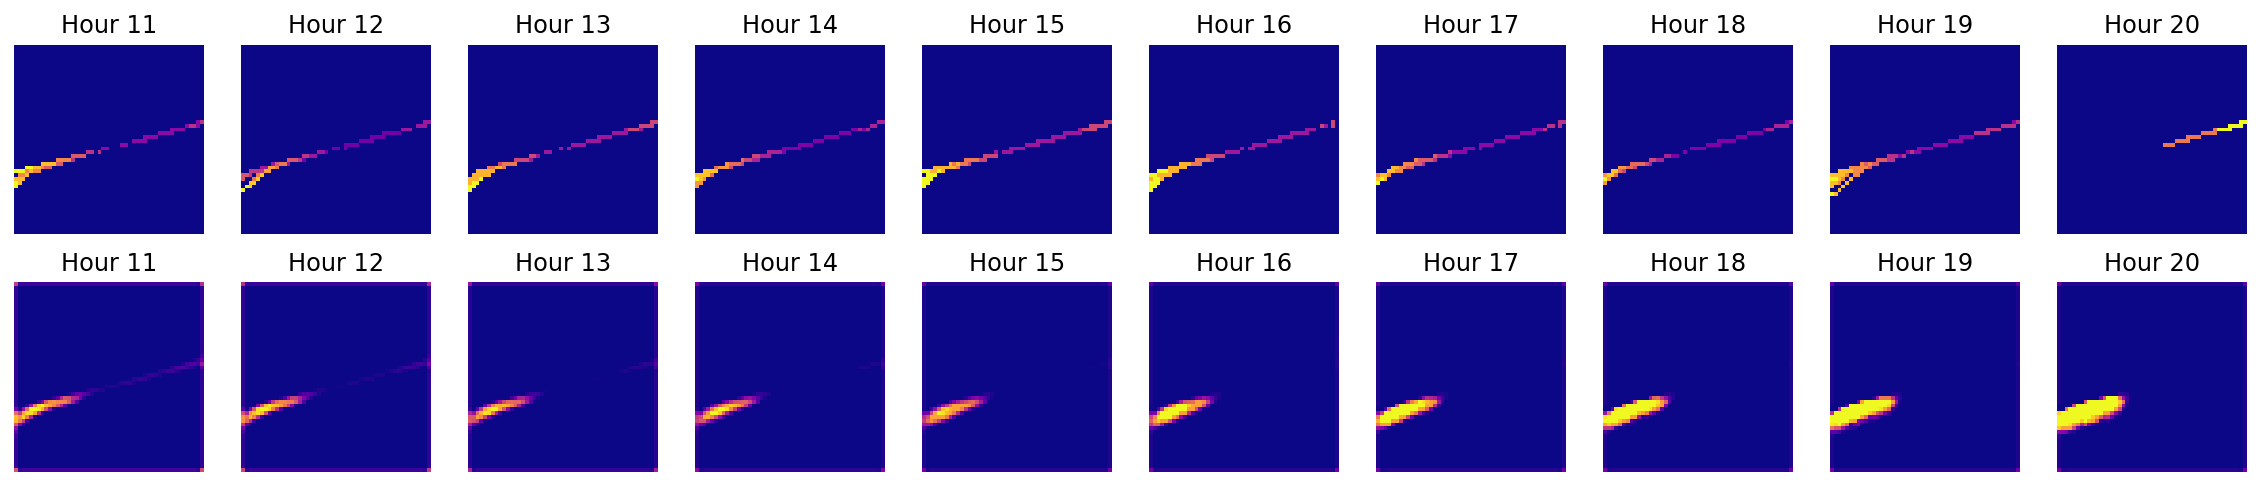

In [398]:
# Select a random example from the validation dataset.
example = x_test[0]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    # new_prediction[new_prediction > .5] = 1
    # new_prediction[new_prediction < .5] = 0

    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
  
    ax.imshow(level_transform(original_frames, idx), origin='lower', cmap = plt.get_cmap('plasma'))
    # ax.imshow(np.amax(original_frames[idx], axis=2), origin='lower')
    ax.set_title(f"Hour {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(level_transform(new_frames, idx), origin='lower', cmap = plt.get_cmap('plasma'))
    # ax.imshow(np.amax(new_frames[idx], axis=2), origin='lower')
    ax.set_title(f"Hour {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()